# Clasificación de deportes

In [1]:
# Importamos las bibliotecas que usaremos en nuestro modelo
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation, Conv2D, MaxPooling2D 
from tensorflow.keras import backend as K
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import SVG
import scipy.io as sio
import sklearn as sk
import pandas as pd
import numpy as np
import os

In [2]:
# Definimos las rutas de las carpetas de las imagenes 
data = 'D:/pepe2/Documents/QuackRepository/Quack/AI/input/data'

# Reescalamos las imagenes a 100x100 pixeles
img_width, img_height = 32, 32

# Definimos el tamaño del batch
batch_size = 32

# Definimos el numero de epocas
epochs = 100

# Definimos el numero de clases
num_classes = 2

# Definimos el numero de datos de entrenamiento
train_samples = 11500

# Definimos el numero de datos de validacion
validation_samples = 2870

# Definimos el numero de filtros
filters = 32

# Definimos el tamaño del kernel
kernel_size = (3, 3)

# Definimos el tamaño del pool
pool_size = (2, 2)

# Definimos el numero de capas
num_layers = 3

# Definimos el numero de neuronas
num_neurons = 128

# Definimos el numero de neuronas de salida
num_output = 2

# Definimos el numero de neuronas de entrada
num_input = 100

Desde un inicio realizamos la normalización de nuestras imágenes

In [3]:
# Normalizamos las imagenes y aplicamos aumentacion de datos
train_datagen = ImageDataGenerator(
    rescale=1. / 255, #Normalizamos las imagenes
    shear_range=0.2,   #Aplicamos cortes aleatorios
    zoom_range=0.2, #Aplicamos zoom aleatorio
    rotation_range=20, #Rotamos las imagenes
    horizontal_flip=True, #Volteamos las imagenes horizontalmente
    validation_split=0.2) #Separamos los datos de entrenamiento y validacion

# Cargamos las imagenes de entrenamiento
train_generator = train_datagen.flow_from_directory(
    data, 
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

# Cargamos las imagenes de validacion
validation_generator = train_datagen.flow_from_directory(
    data,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 11494 images belonging to 22 classes.
Found 2863 images belonging to 22 classes.


In [4]:
#Mostramos las clases
print(train_generator.class_indices)

{'badminton': 0, 'baseball': 1, 'basketball': 2, 'boxing': 3, 'chess': 4, 'cricket': 5, 'fencing': 6, 'football': 7, 'formula1': 8, 'gymnastics': 9, 'hockey': 10, 'ice_hockey': 11, 'kabaddi': 12, 'motogp': 13, 'shooting': 14, 'swimming': 15, 'table_tennis': 16, 'tennis': 17, 'volleyball': 18, 'weight_lifting': 19, 'wrestling': 20, 'wwe': 21}


Dado que nuestro problema es de clasificación multiclase y sólo nos fijamos en los rasgos de las imágenes, no hay necesidad de aplicar transfer learning, pues desde el primer entrenamiento podremos observar que la red empieza a clasificar adecuadamente las imágenes.

Por esta misma razón realizamos una red de dos capas convolutivas en 2D, con un drop out del 0.25 y una capa de salida con la misma cantidad de neuronas que de clases y función de activación softmax.

In [11]:
#Definimos el modelo
def model_sports():
    model = Sequential() #Escogemos el modelo secuencial
    model.add(Conv2D(32, kernel_size, padding='same', activation='relu', input_shape=(img_width, img_height, 3))) #Añadimos la primera capa de convolucion
    model.add(MaxPooling2D(pool_size=pool_size)) #Añadimos la primera capa de pooling de 2x2
    model.add(Conv2D(64, kernel_size, padding='same', activation='relu')) #Añadimos la segunda capa de convolucion
    model.add(MaxPooling2D(pool_size=pool_size)) #Añadimos la segunda capa de pooling de 2x2
    model.add(Dropout(0.25))
    model.add(Flatten()) #Aplicamos la funcion de aplanamiento para convertir la matriz en un vector
    model.add(Dense(num_neurons,activation='relu')) #Añadimos una capa densa para conectar todas las neuronas de la capa anterior
    model.add(Dense(22, activation='softmax')) #Añadimos una capa densa de salida con 23 neuronas y funcion de activacion softmax
    return model

In [12]:
model = model_car_bike() #Guardamos el modelo en una variable

In [13]:
model.summary() #Mostramos un resumen del modelo

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 4096)             

Utilizamos:
- Función de pérdida: categorical crossentropy, dada la naturaleza multiclasificación del problema.
- Optimizador: Adam, con lr=0.001
- Métrica: Accuracy

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #Compilamos el modelo con la funcion de perdida binary_crossentropy, el optimizador adam y la metrica accuracy

In [15]:
# Calculamos los validation steps
validation_steps = validation_samples // batch_size
validation_steps

89

In [16]:
#Utilizamos keras.fit_generator para entrenar el modelo
history = model.fit_generator(
    train_generator, #Utilizamos el generador de imagenes de entrenamiento
    steps_per_epoch=20, #Definimos el numero de pasos por epoca
    epochs=epochs, #Definimos el numero de epocas
    validation_data=validation_generator, #Utilizamos el generador de imagenes de validacion
    validation_steps=validation_steps) #Definimos el numero de pasos por epoca de validacion

C:\Users\pepe2\AppData\Local\Temp\ipykernel_14912\2730122414.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
20/20 [==============================] - 19s 900ms/step - loss: 3.0911 - accuracy: 0.0703 - val_loss: 3.0555 - val_accuracy: 0.0955
Epoch 2/100
20/20 [==============================] - 18s 921ms/step - loss: 3.0188 - accuracy: 0.1109 - val_loss: 2.9622 - val_accuracy: 0.1271
Epoch 3/100
20/20 [==============================] - 17s 850ms/step - loss: 2.9510 - accuracy: 0.1297 - val_loss: 2.8284 - val_accuracy: 0.1822
Epoch 4/100
20/20 [==============================] - 17s 872ms/step - loss: 2.7953 - accuracy: 0.1656 - val_loss: 2.6681 - val_accuracy: 0.1980
Epoch 5/100
20/20 [==============================] - 15s 763ms/step - loss: 2.7806 - accuracy: 0.1609 - val_loss: 2.5994 - val_accuracy: 0.2037
Epoch 6/100
20/20 [==============================] - 16s 809ms/step - loss: 2.6555 - accuracy: 0.2266 - val_loss: 2.4765 - val_accuracy: 0.2402
Epoch 7/100
20/20 [==============================] - 14s 732ms/step - loss: 2.7038 - accuracy: 0.2016 - val_loss: 2.5112 - val_accuracy:

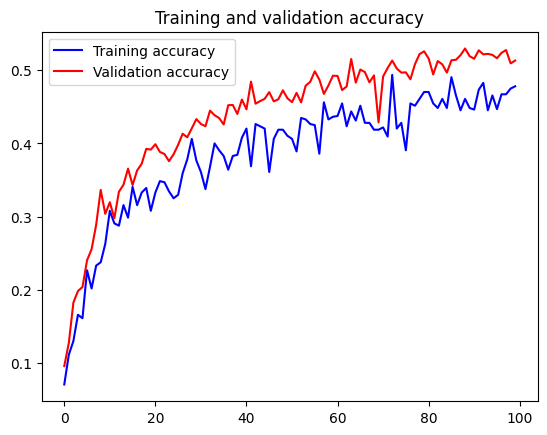

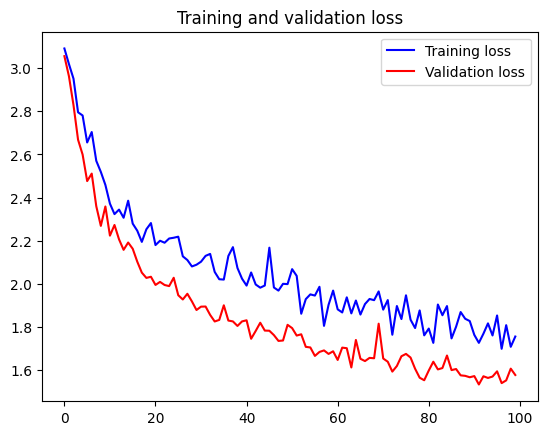

In [17]:
# Guardamos el modelo
model.save_weights('model__sports_saved.h5')

# Graficamos la precision y la perdida del modelo
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Graficamos la precision del modelo
epochs = range(len(acc))
plt.figure()
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Graficamos la perdida del modelo
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


Observamos que existe un Overfitting en nuestro modelo, por lo que aplicaremos data augmentation como solución:

In [18]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [29]:
def model_sports2():
    model = Sequential() #Escogemos el modelo secuencial
    model.add(Conv2D(32, kernel_size, padding='same', activation='relu', input_shape=(img_width, img_height, 3))) #Añadimos la primera capa de convolucion
    model.add(MaxPooling2D(pool_size=pool_size)) #Añadimos la primera capa de pooling de 2x2
    model.add(Conv2D(64, kernel_size, padding='same', activation='relu')) #Añadimos la segunda capa de convolucion
    model.add(MaxPooling2D(pool_size=pool_size)) #Añadimos la segunda capa de pooling de 2x2
    model.add(Dropout(0.5))
    model.add(Flatten()) #Aplicamos la funcion de aplanamiento para convertir la matriz en un vector
    model.add(Dense(num_neurons,activation='relu')) #Añadimos una capa densa para conectar todas las neuronas de la capa anterior
    model.add(Dense(22, activation='softmax')) #Añadimos una capa densa de salida con 23 neuronas y funcion de activacion softmax
    return model

In [30]:
model2 = model_car_bike() #Guardamos el modelo en una variable
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #Compilamos el modelo con la funcion de perdida binary_crossentropy, el optimizador adam y la metrica accuracy

In [31]:
# Calculamos los validation steps
validation_steps = validation_samples // batch_size
validation_steps

#Utilizamos keras.fit_generator para entrenar el modelo
history = model2.fit_generator(
    train_generator, #Utilizamos el generador de imagenes de entrenamiento
    steps_per_epoch=20, #Definimos el numero de pasos por epoca
    epochs=50, #Definimos el numero de epocas
    validation_data=validation_generator, #Utilizamos el generador de imagenes de validacion
    validation_steps=validation_steps) #Definimos el numero de pasos por epoca de validacion

Epoch 1/50


C:\Users\pepe2\AppData\Local\Temp\ipykernel_14912\3603911725.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model2.fit_generator(


20/20 [==============================] - 10s 477ms/step - loss: 3.0920 - accuracy: 0.0578 - val_loss: 3.0331 - val_accuracy: 0.1081
Epoch 2/50
20/20 [==============================] - 9s 460ms/step - loss: 2.9552 - accuracy: 0.1156 - val_loss: 2.8634 - val_accuracy: 0.1566
Epoch 3/50
20/20 [==============================] - 9s 469ms/step - loss: 2.8749 - accuracy: 0.1609 - val_loss: 2.7134 - val_accuracy: 0.2079
Epoch 4/50
20/20 [==============================] - 8s 430ms/step - loss: 2.8021 - accuracy: 0.1578 - val_loss: 2.5739 - val_accuracy: 0.2114
Epoch 5/50
20/20 [==============================] - 8s 399ms/step - loss: 2.6577 - accuracy: 0.2078 - val_loss: 2.5626 - val_accuracy: 0.2532
Epoch 6/50
20/20 [==============================] - 8s 391ms/step - loss: 2.6053 - accuracy: 0.2156 - val_loss: 2.4349 - val_accuracy: 0.2774
Epoch 7/50
20/20 [==============================] - 8s 397ms/step - loss: 2.5616 - accuracy: 0.2375 - val_loss: 2.3718 - val_accuracy: 0.3072
Epoch 8/50
20/20

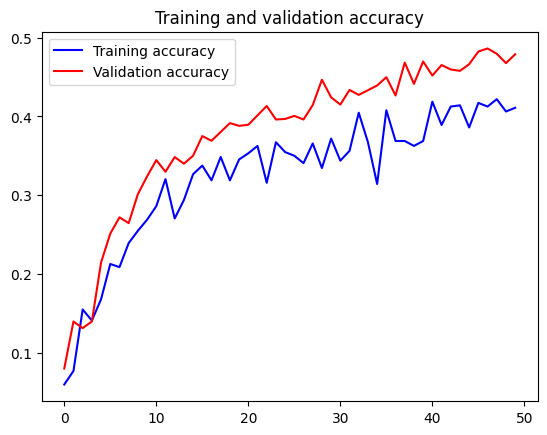

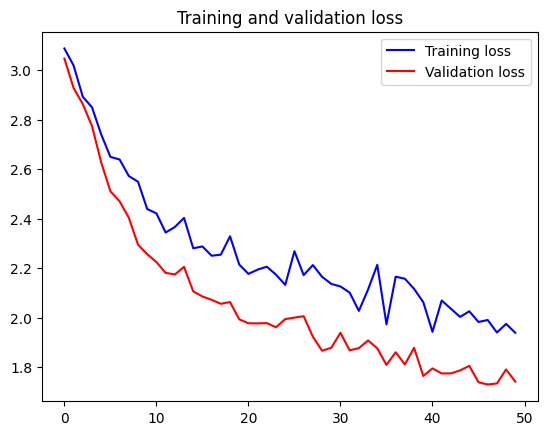

In [28]:
# Guardamos el modelo
model.save_weights('model__sports_saved.h5')

# Graficamos la precision y la perdida del modelo
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Graficamos la precision del modelo
epochs = range(len(acc))
plt.figure()
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Graficamos la perdida del modelo
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [19]:
# Hacemos una prediccion del modelo de clases con una imagen desde el directorio
print(train_generator.class_indices)

{'badminton': 0, 'baseball': 1, 'basketball': 2, 'boxing': 3, 'chess': 4, 'cricket': 5, 'fencing': 6, 'football': 7, 'formula1': 8, 'gymnastics': 9, 'hockey': 10, 'ice_hockey': 11, 'kabaddi': 12, 'motogp': 13, 'shooting': 14, 'swimming': 15, 'table_tennis': 16, 'tennis': 17, 'volleyball': 18, 'weight_lifting': 19, 'wrestling': 20, 'wwe': 21}


In [20]:
type(train_generator.class_indices)

# Guardamos las clases en un array
classes = []
for key in train_generator.class_indices:
    classes.append(key)
    
classes

['badminton',
 'baseball',
 'basketball',
 'boxing',
 'chess',
 'cricket',
 'fencing',
 'football',
 'formula1',
 'gymnastics',
 'hockey',
 'ice_hockey',
 'kabaddi',
 'motogp',
 'shooting',
 'swimming',
 'table_tennis',
 'tennis',
 'volleyball',
 'weight_lifting',
 'wrestling',
 'wwe']

In [21]:
# Hacemos una prediccion del modelo con una imagen desde el directorio
from tensorflow.keras.preprocessing import image
import numpy as np

img_pred = image.load_img('D:\pepe2\Documents\QuackRepository\Quack\Redes Neuronales\swim_prueba.jpg', target_size=(32, 32))

In [22]:
def prediction(img_pred):
    img_pred_1 = image.img_to_array(img_pred)
    img_pred_1 = np.expand_dims(img_pred, axis=0)
    rslt = model.predict(img_pred_1)
    plt.imshow(img_pred)
    plt.show()
    for i in range(len(classes)):
        if rslt[0][i] == 1.0:
            return classes[i]
    

1/1 [==============================] - 0s 171ms/step


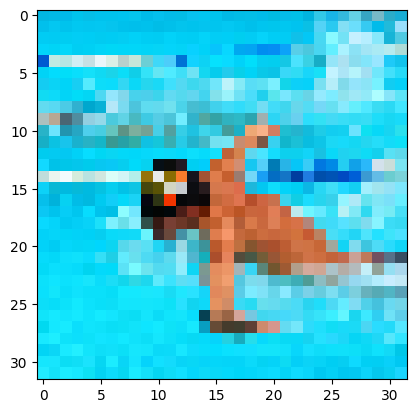

'swimming'

In [23]:
prediction(img_pred)

1/1 [==============================] - 0s 66ms/step


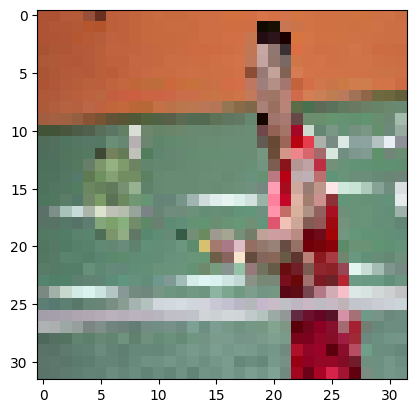

'badminton'

In [24]:
img_pred = image.load_img('D:\pepe2\Documents\QuackRepository\Quack\Redes Neuronales\prueba_2.jpg', target_size=(32, 32))
prediction(img_pred)